In [73]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

In [74]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [75]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [76]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

      unrate  psr       m2    dspic      pce    reer       

In [77]:
ticker='TSLA'

In [78]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [79]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [80]:
dates = pd.to_datetime(df['Date'])

In [81]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [82]:
df_for_training = df[cols].astype(float)

In [83]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [84]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [85]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [86]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [87]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [88]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 16)
(1251, 1)


In [89]:
size=1125
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]


#early stopping


Epoch 1/100


4/4 [==============================] - 1s 55ms/step - loss: 0.2805 - val_loss: 0.2729
Epoch 2/100
4/4 [==============================] - 0s 28ms/step - loss: 0.1429 - val_loss: 0.1491
Epoch 3/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0636 - val_loss: 0.0758
Epoch 4/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0219 - val_loss: 0.0342
Epoch 5/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0049 - val_loss: 0.0122
Epoch 6/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 7/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0085 - val_loss: 0.0027
Epoch 8/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0122 - val_loss: 0.0026
Epoch 9/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0119 - val_loss: 0.0028
Epoch 10/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0092 - val_loss: 0.0040
Epoch 11/100
4/4 [=============

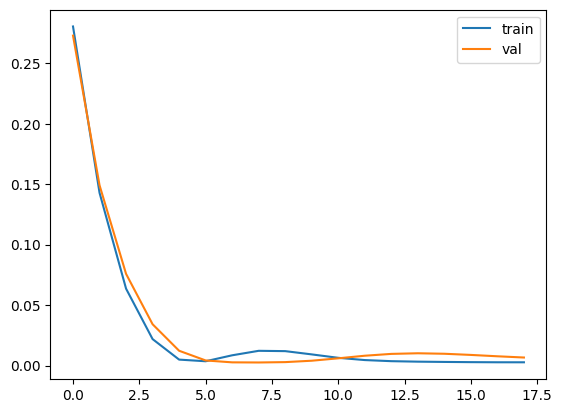

4/4 [==============================] - 0s 3ms/step
mae: 5.312409994486008
(126,)
(126,)


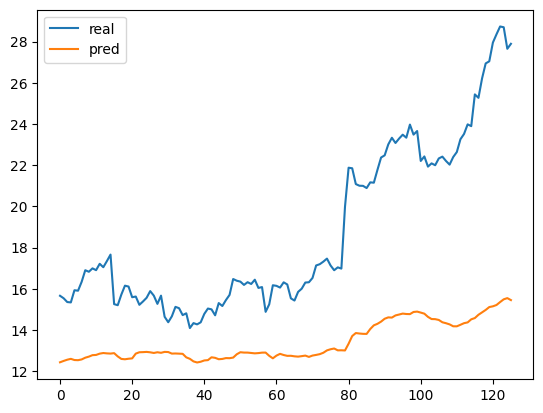

Epoch 1/100
7/7 [==============================] - 1s 43ms/step - loss: 0.0879 - val_loss: 0.0084
Epoch 2/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0105 - val_loss: 0.0273
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0071 - val_loss: 0.0439
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0070 - val_loss: 0.0279
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0036 - val_loss: 0.0158
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0040 - val_loss: 0.0128
Epoch 7/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0039 - val_loss: 0.0146
Epoch 8/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0030 - val_loss: 0.0176
Epoch 9/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0027 - val_loss: 0.0183
Epoch 10/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0026 - val_loss: 0.0166
Epoch 11/100
7/7 [=

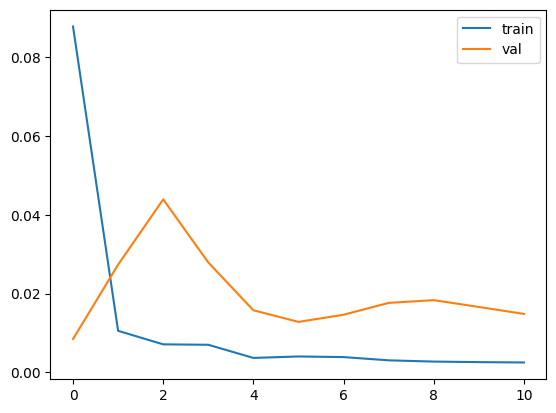

4/4 [==============================] - 0s 3ms/step
mae: 2.496904570750403
(126,)
(126,)


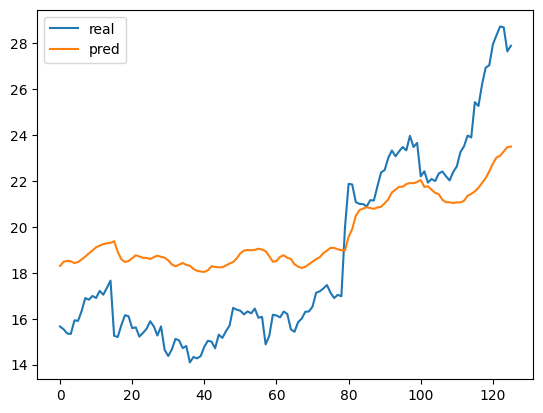

Epoch 1/100
10/10 [==============================] - 1s 31ms/step - loss: 0.1881 - val_loss: 0.0208
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0278 - val_loss: 0.0110
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0119 - val_loss: 0.0174
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 5/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 6/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 7/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 8/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 9/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 9.0890e-04
Epoch 10/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 8.

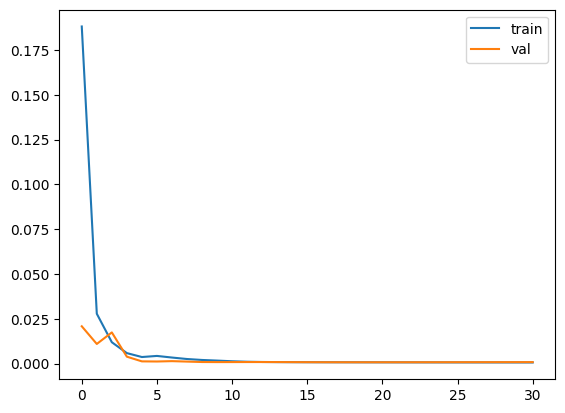

4/4 [==============================] - 0s 4ms/step
mae: 1.7228756056562153
(126,)
(126,)


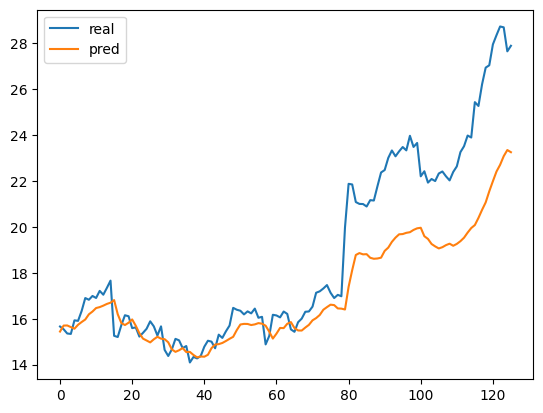

Epoch 1/100
13/13 [==============================] - 1s 30ms/step - loss: 0.0099 - val_loss: 0.0027
Epoch 2/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0072 - val_loss: 7.5039e-04
Epoch 3/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 4/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 5/100
13/13 [==============================] - 0s 20ms/step - loss: 9.8092e-04 - val_loss: 0.0014
Epoch 6/100
13/13 [==============================] - 0s 21ms/step - loss: 8.2063e-04 - val_loss: 0.0015
Epoch 7/100
13/13 [==============================] - 0s 22ms/step - loss: 7.6179e-04 - val_loss: 0.0011
Epoch 8/100
13/13 [==============================] - 0s 21ms/step - loss: 7.0113e-04 - val_loss: 9.7649e-04
Epoch 9/100
13/13 [==============================] - 0s 21ms/step - loss: 7.0519e-04 - val_loss: 0.0011
Epoch 10/100
13/13 [==============================] - 0s 22ms/step - los

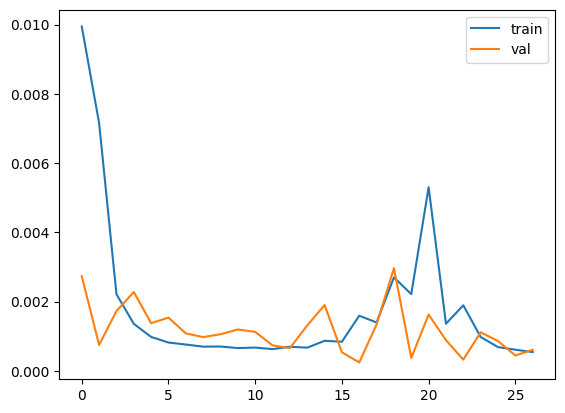

4/4 [==============================] - 0s 2ms/step
mae: 5.259998628679547
(126,)
(126,)


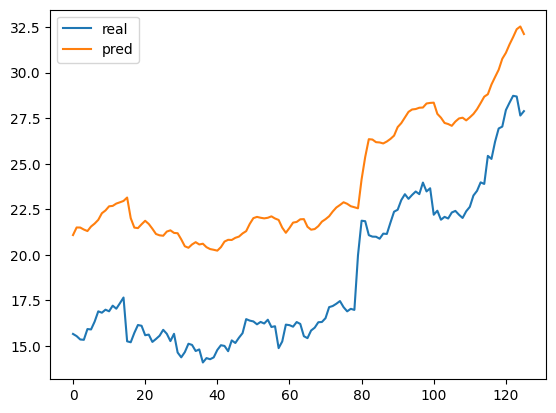

Epoch 1/100
17/17 [==============================] - 1s 25ms/step - loss: 0.0058 - val_loss: 0.0262
Epoch 2/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0064 - val_loss: 0.0096
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0029 - val_loss: 0.0217
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0027 - val_loss: 0.0118
Epoch 5/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 6/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0076
Epoch 7/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 0.0150
Epoch 8/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0068
Epoch 9/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0020 - val_loss: 0.0049

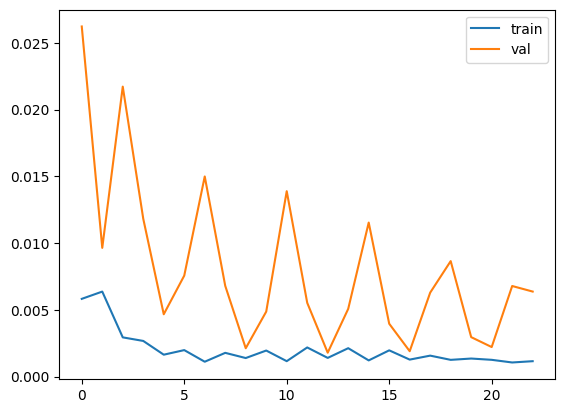

4/4 [==============================] - 0s 3ms/step
mae: 2.829801850900801
(126,)
(126,)


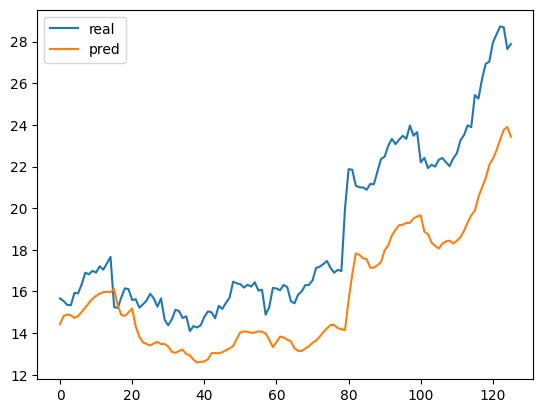

Epoch 1/100
20/20 [==============================] - 1s 24ms/step - loss: 0.0125 - val_loss: 0.0195
Epoch 2/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0285 - val_loss: 0.0428
Epoch 3/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 4/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 6/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0063
Epoch 7/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 8/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 10/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 0.0081

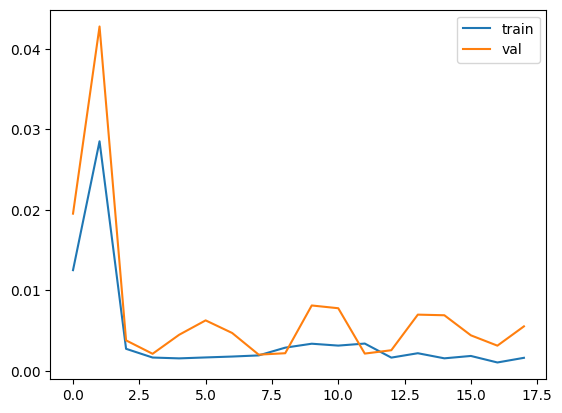

4/4 [==============================] - 0s 5ms/step
mae: 3.058562649841309
(126,)
(126,)


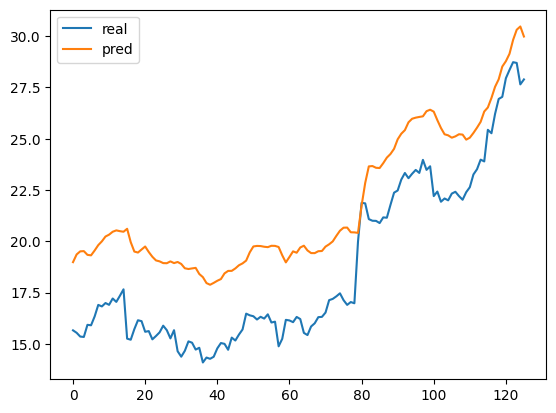

Epoch 1/100
23/23 [==============================] - 1s 24ms/step - loss: 0.0246 - val_loss: 0.0033
Epoch 2/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0222 - val_loss: 0.0020
Epoch 3/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0131 - val_loss: 0.0037
Epoch 4/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0156 - val_loss: 0.0071
Epoch 5/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0032
Epoch 6/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 7/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 8/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 10/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0018

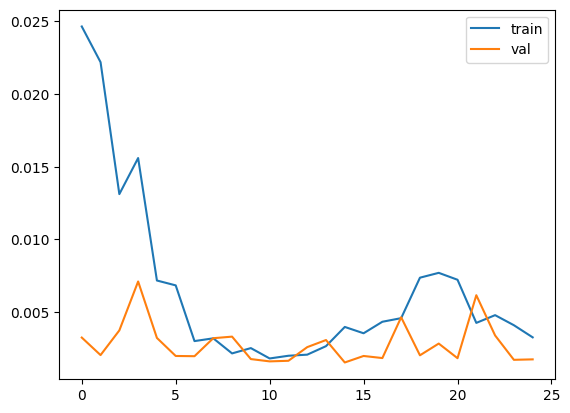

4/4 [==============================] - 0s 3ms/step
mae: 0.9210615555109902
(126,)
(126,)


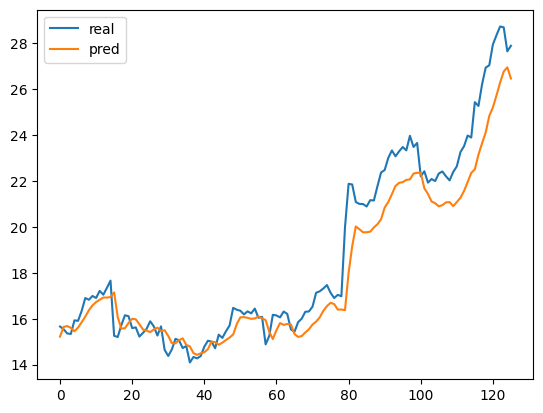

Epoch 1/100
26/26 [==============================] - 1s 23ms/step - loss: 0.0113 - val_loss: 0.0102
Epoch 2/100
26/26 [==============================] - 1s 19ms/step - loss: 0.0189 - val_loss: 0.0033
Epoch 3/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 4/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 5/100
26/26 [==============================] - 1s 19ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 7/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 8/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0027 - val_loss: 0.0082
Epoch 9/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0033 - val_loss: 0.0128
Epoch 10/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0037 - val_loss: 0.0030

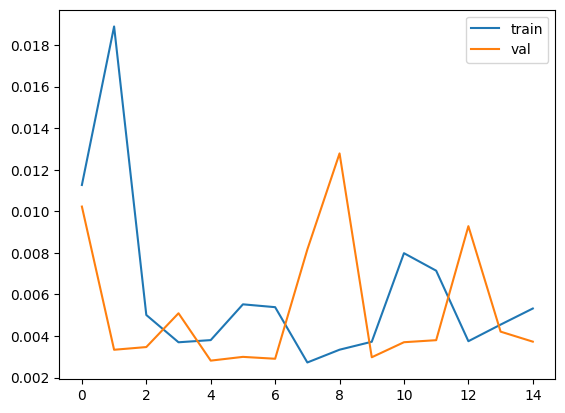

4/4 [==============================] - 0s 3ms/step
mae: 1.1997465270293703
(126,)
(126,)


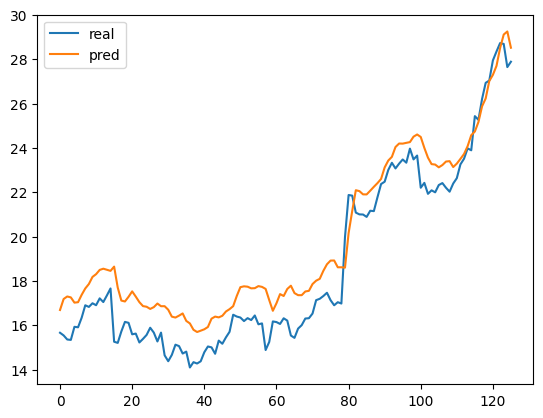

Epoch 1/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0379 - val_loss: 0.0670
Epoch 2/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0175 - val_loss: 0.0271
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0096 - val_loss: 0.0105
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 6/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0079 - val_loss: 0.0180
Epoch 7/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0085
Epoch 8/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0084 - val_loss: 0.0045
Epoch 9/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 10/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0104 - val_loss: 0.0046

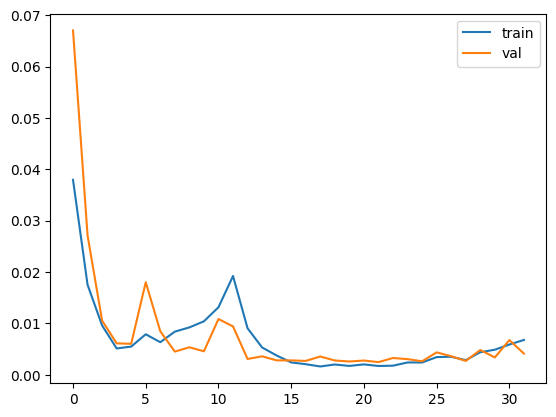

4/4 [==============================] - 0s 3ms/step
mae: 2.455768678970579
(126,)
(126,)


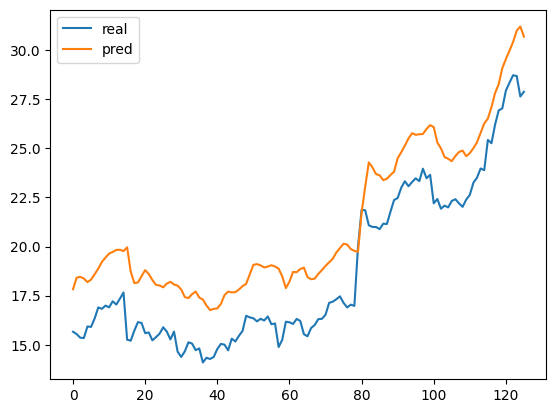

Epoch 1/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0556 - val_loss: 0.0142
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0404 - val_loss: 0.0579
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0184 - val_loss: 0.0121
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 8/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 10/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0024 - val_loss: 0.0022

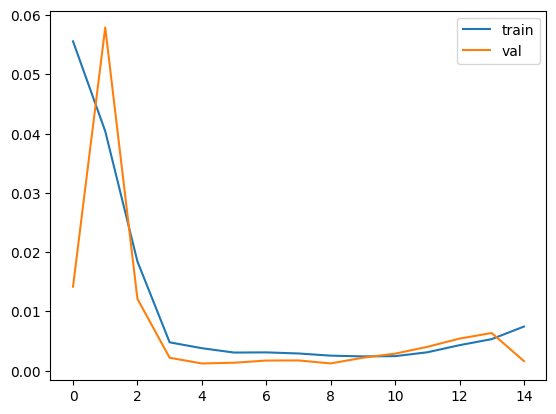

4/4 [==============================] - 0s 2ms/step
mae: 2.425671422344389
(126,)
(126,)


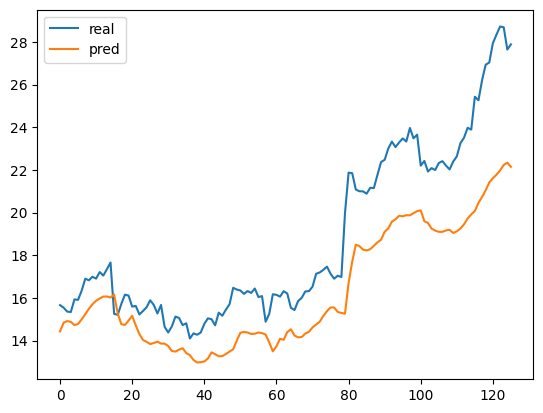

In [90]:
tscv = TimeSeriesSplit(n_splits=10)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    
    print('mae:',np.mean(np.abs(pred-y_test)))

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
